# Anomaly Detection on Synthetic Data with Concept Drift Adaptation

This notebook demonstrates the experiments on synthetic data run as part of the MSc thesis "Stream Learning for Anomaly Detection with Concept Drift Adaptation: Applications to Credit Card Fraud Detection" by Loredana Sandu, submitted to the Open University of Catalonia in 2024 as part of the Master in Computational and Mathematical Engineering.

**Table of contents:**
- [1. Generation of synthetic data with anomalies](#toc1)
- [2. Anomaly detection algorithms (without concept drift adaptation)](#toc2)    
    - [2.1. Baseline algorithms without hyperparameter tuning](#toc21)    
    - [2.2. Algorithms with hyperparameter tuning](#toc22)    
- [3. Concept drift detection algorithms](#toc3)    
- [4. Anomaly detection algorithms with concept drift adaptation](#toc4)

In [1]:
from river import stream
from river import anomaly
from river import metrics
from river import drift
from river import utils
from river import compose
from river import preprocessing

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from tqdm import tqdm

np.random.seed(42)

## <a id='toc1'></a>1. Generation of synthetic data with anomalies and concept drift

In [2]:
N_DISTS = 3          # Number of distributions in the stream (therefore, there will be N_DIST-1 drifts)
N_SAMPLES = 10000   # Number of samples for each distribution
N_ANOMALIES = 100   # Number of anomalies for each distribution

def generate_random_data(n_dists, n_samples, n_anomalies):
    """
    Generate random data following a normal distribution, with 
    random mean and standard deviation.

    INPUTS:
    - n_dists: int, number of distributions to generate
    - n_samples: int, number of samples to generate
    - n_anomalies: int, number of anomalies to insert

    OUTPUTS:
    - dists: list of arrays, each array is a distribution
    - anomalies: list of arrays, each array is a list of 0s and 1s, 
        1s indicate anomalies in the corresponding distribution
    """
    # Fix random seed for reproducibility
    np.random.seed(2)

    # Generate random means and standard deviations for the distributions
    mean = np.random.uniform(0, 1, n_dists)
    std = np.random.uniform(0.01, 0.1, n_dists)

    dists = []
    anomalies = []
    for i in range(n_dists):
        # Generate distribution
        dist = np.random.normal(mean[i], std[i], n_samples)

        # Insert anomalies
        anomalies_dist = np.zeros(n_samples).astype(int)
        for _ in range(n_anomalies):
            random_idx = np.random.randint(0, n_samples)
            random_sign = np.random.choice([-1, 1])
            dist[random_idx] = dist[random_idx] + random_sign * 5 * np.random.uniform(std[i], 2*std[i])
            anomalies_dist[random_idx] = 1
        anomalies.append(anomalies_dist)

        dists.append(dist)

    return dists, anomalies



# Generate data for 3 normal distributions
dists, anomalies_dists = generate_random_data(N_DISTS, N_SAMPLES, N_ANOMALIES)

# Concatenate the data to create a stream with 2 concept drifts
data = np.concatenate(dists)
anomalies = np.concatenate(anomalies_dists)

# Convert the data to a dataframe
df = pd.DataFrame(columns=['dist', 'values', 'anomaly'])
dist_names = ['dist{}'.format(i+1) for i in range(N_DISTS) for _ in range(N_SAMPLES)]
df['dist'] = dist_names
df['values'] = data
df['anomaly'] = anomalies

df

,dist,values,anomaly
0,dist1,0.460726,0
1,dist1,0.374753,0
2,dist1,0.383966,0
3,dist1,0.391291,0
4,dist1,0.463115,0
...,...,...,...
29995,dist3,0.566004,0
29996,dist3,0.577589,0
29997,dist3,0.563152,0
29998,dist3,0.525673,0


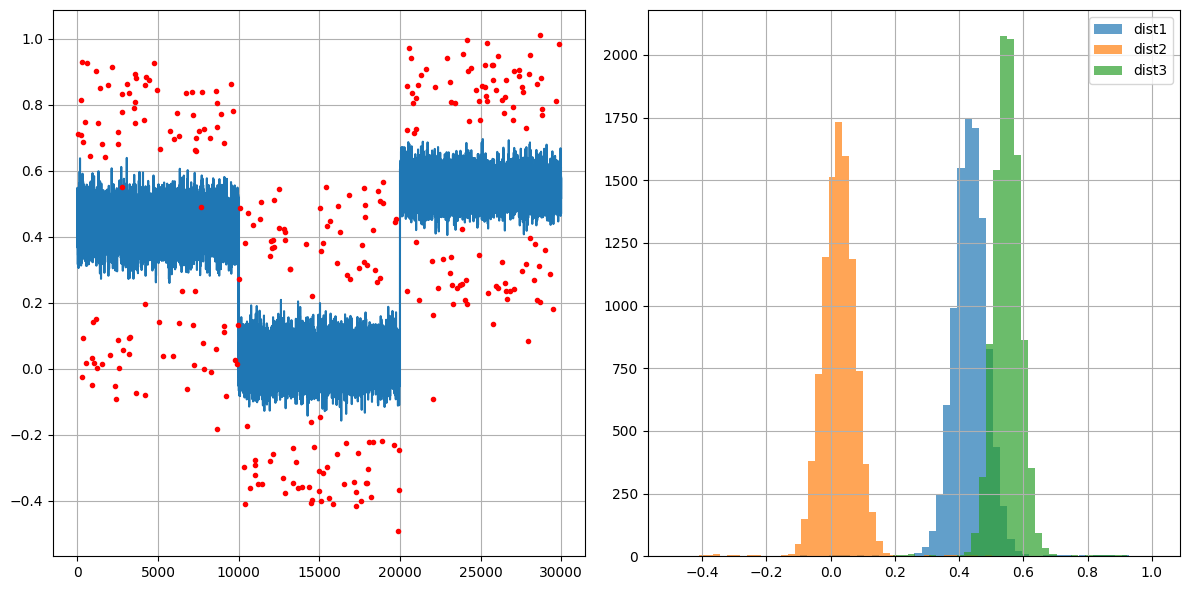

In [3]:
# Plot the data
def plot_stream(df, drifts=None):
    fig = plt.figure(figsize=(12,6), tight_layout=True)
    ax1 = fig.add_subplot(1, 2, 1)
    ax2 = fig.add_subplot(1, 2, 2)
    
    df_normal = df[df['anomaly'] == 0]
    df_anomalous = df[df['anomaly'] == 1]
    ax1.plot(df_normal.index, df_normal['values'], label='normal')
    ax1.plot(df_anomalous.index, df_anomalous['values'], 'r.', label='anomaly')

    for i in range(1, N_DISTS+1):
        df_dist = df[df['dist'] == 'dist{}'.format(i)]
        ax2.hist(df_dist['values'], bins=50, alpha=0.7, label='dist{}'.format(i))

    if drifts is not None:
        for drift_detected in drifts:
            ax1.axvline(drift_detected, color='red')

    ax1.grid()
    ax2.grid()
    ax2.legend()
    plt.show()

plot_stream(df)

## <a id='toc2'></a>2. Anomaly detection algorithms (without concept drift adaptation)

In [4]:
def run_and_evaluate_model(scaler, model, X, y, progress_bar=True):
    """
    Run the scaler and the model on the data and evaluate its performance.

    INPUTS:
    - scaler: the scaler to normalize the data
    - model: river.anomaly.base.AnomalyDetector, the anomaly detection model
    - X: pd.DataFrame containing the features
    - y: pd.Series containing the labels
    - progress_bar: bool, whether to show a progress bar or not

    OUTPUTS:
    - metrics_results: dict, the results of the evaluated metrics
    """
    precision = metrics.Precision()
    recall = metrics.Recall()
    f1 = metrics.F1()
    balanced_accuracy = metrics.BalancedAccuracy()
    rocauc = metrics.ROCAUC()

    metrics_results = {
        'precision': [],
        'recall': [],
        'f1': [],
        'balanced_accuracy': [],
        'rocauc': []
    }

    if progress_bar:
        data_stream = tqdm(stream.iter_pandas(X, y), total=N_SAMPLES*3)
    else:
        data_stream = stream.iter_pandas(X, y)

    for x, y in data_stream:

        scaler.learn_one(x)
        x = scaler.transform_one(x)

        try:
            score = model.score_one(x)
        except:
            score = model.score_one(x, y)

        is_anomaly = model.classify(score)

        try:
            model.learn_one(x)
        except:
            model.learn_one(x, y)

        rocauc.update(y, score)
        precision.update(y, is_anomaly)
        recall.update(y, is_anomaly)
        f1.update(y, is_anomaly)
        balanced_accuracy.update(y, is_anomaly)

        metrics_results['precision'].append(precision.get())
        metrics_results['recall'].append(recall.get())
        metrics_results['f1'].append(f1.get())
        metrics_results['balanced_accuracy'].append(balanced_accuracy.get())
        metrics_results['rocauc'].append(rocauc.get())

    return metrics_results

### <a id='toc21'></a>2.1. Baseline algorithms without hyperparameter tuning

#### Half-Space Trees

In [5]:
scaler = preprocessing.MinMaxScaler()

model = anomaly.QuantileFilter(
    anomaly.HalfSpaceTrees(seed=42),
    q=0.99
)

X = df[['values']]
y = df['anomaly']

metrics_results = run_and_evaluate_model(scaler, model, X, y)

print(f"Precision: {metrics_results['precision'][-1]*100:.2f}")
print(f"Recall: {metrics_results['recall'][-1]*100:.2f}")
print(f"F1 Score: {metrics_results['f1'][-1]*100:.2f}")
print(f"Balanced accuracy: {metrics_results['balanced_accuracy'][-1]*100:.2f}")
print(f"ROCAUC: {metrics_results['rocauc'][-1]*100:.2f}")

100%|██████████| 30000/30000 [00:13<00:00, 2221.75it/s]

Precision: 28.34
Recall: 29.19
F1 Score: 28.76
Balanced accuracy: 64.23
ROCAUC: 90.30


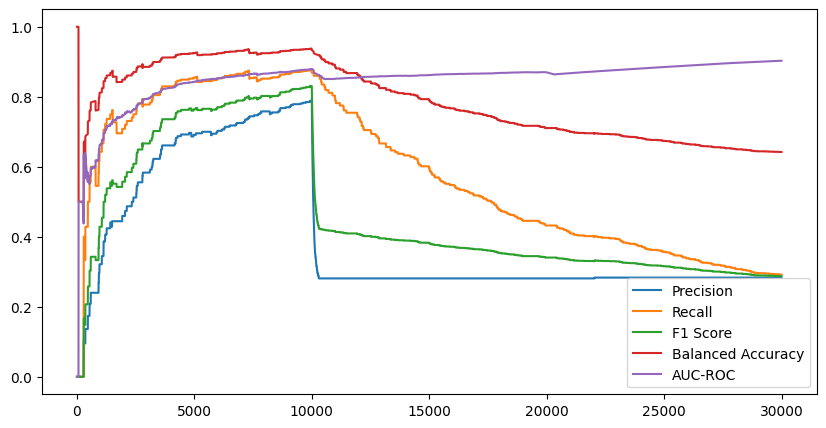

In [6]:
plt.figure(figsize=(10, 5))
plt.plot(metrics_results['precision'], label='Precision')
plt.plot(metrics_results['recall'], label='Recall')
plt.plot(metrics_results['f1'], label='F1 Score')
plt.plot(metrics_results['balanced_accuracy'], label='Balanced Accuracy')
plt.plot(metrics_results['rocauc'], label='AUC-ROC')
plt.xticks(range(0, N_SAMPLES*3+1, 5000))
plt.legend()
plt.show()

#### One-Class SVM

In [7]:
scaler = preprocessing.MinMaxScaler()

model = anomaly.QuantileFilter(
    anomaly.OneClassSVM(),
    q=0.99
)

X = df[['values']]
y = df['anomaly']

metrics_results = run_and_evaluate_model(scaler, model, X, y)

print(f"Precision: {metrics_results['precision'][-1]*100:.2f}")
print(f"Recall: {metrics_results['recall'][-1]*100:.2f}")
print(f"F1 Score: {metrics_results['f1'][-1]*100:.2f}")
print(f"Balanced accuracy: {metrics_results['balanced_accuracy'][-1]*100:.2f}")
print(f"ROCAUC: {metrics_results['rocauc'][-1]*100:.2f}")

100%|██████████| 30000/30000 [00:08<00:00, 3739.24it/s]

Precision: 4.21
Recall: 36.91
F1 Score: 7.56
Balanced accuracy: 64.24
ROCAUC: 49.68


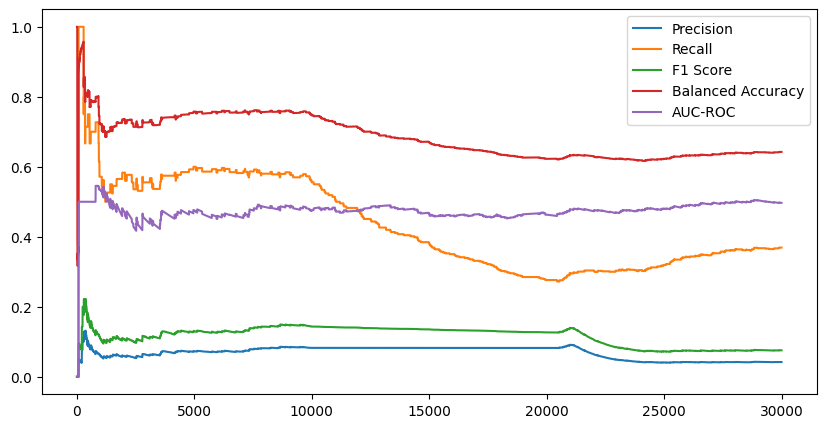

In [8]:
plt.figure(figsize=(10, 5))
plt.plot(metrics_results['precision'], label='Precision')
plt.plot(metrics_results['recall'], label='Recall')
plt.plot(metrics_results['f1'], label='F1 Score')
plt.plot(metrics_results['balanced_accuracy'], label='Balanced Accuracy')
plt.plot(metrics_results['rocauc'], label='AUC-ROC')
plt.xticks(range(0, N_SAMPLES*3+1, 5000))
plt.legend()
plt.show()

#### Gaussian Scorer

In [9]:
scaler = preprocessing.MinMaxScaler()

model = anomaly.QuantileFilter(
    anomaly.GaussianScorer(),
    q=0.99
)

X = df[['values']]
y = df['anomaly']

metrics_results = run_and_evaluate_model(scaler, model, X, y)

print(f"Precision: {metrics_results['precision'][-1]*100:.2f}")
print(f"Recall: {metrics_results['recall'][-1]*100:.2f}")
print(f"F1 Score: {metrics_results['f1'][-1]*100:.2f}")
print(f"Balanced accuracy: {metrics_results['balanced_accuracy'][-1]*100:.2f}")
print(f"ROCAUC: {metrics_results['rocauc'][-1]*100:.2f}")

100%|██████████| 30000/30000 [00:04<00:00, 6371.03it/s]

Precision: 96.12
Recall: 99.66
F1 Score: 97.86
Balanced accuracy: 99.81
ROCAUC: 99.83


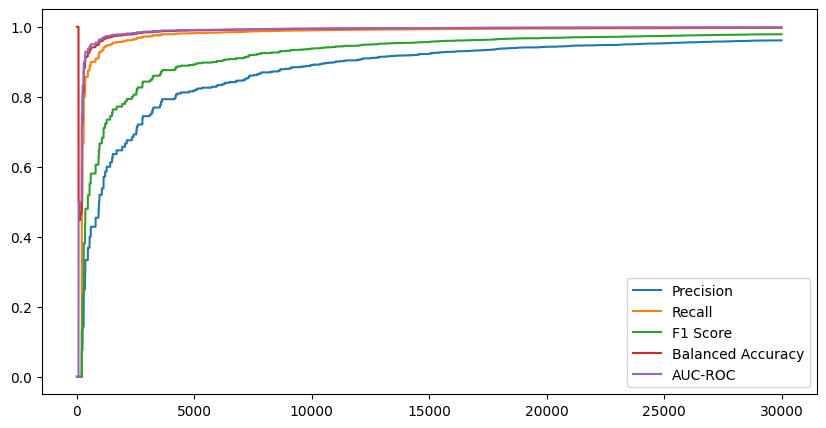

In [10]:
plt.figure(figsize=(10, 5))
plt.plot(metrics_results['precision'], label='Precision')
plt.plot(metrics_results['recall'], label='Recall')
plt.plot(metrics_results['f1'], label='F1 Score')
plt.plot(metrics_results['balanced_accuracy'], label='Balanced Accuracy')
plt.plot(metrics_results['rocauc'], label='AUC-ROC')
plt.xticks(range(0, N_SAMPLES*3+1, 5000))
plt.legend()
plt.show()

#### Local Outlier Factor

This model has been tested and it is too slow to run. It has been tried with different dataset sizes distance functions and number of neighbors, but it is still too slow. Therefore, it is commented out and not included in the final experiments.

In [11]:
scaler = preprocessing.MinMaxScaler()

model = anomaly.QuantileFilter(
    anomaly.LocalOutlierFactor(n_neighbors=2),
    q=0.95
)

X = df[['values']]
y = df['anomaly']

# metrics_results = run_and_evaluate_model(scaler, model, X, y)

### <a id='toc22'></a>2.2. Algorithms with hyperparameter tuning

#### Half-Space Trees

In [12]:
scaler = preprocessing.MinMaxScaler()

model = anomaly.QuantileFilter(
    anomaly_detector=anomaly.HalfSpaceTrees(),
    q=0.95
)

X = df[['values']]
y = df['anomaly']

grid = {
    'anomaly_detector': [
        (anomaly.HalfSpaceTrees, {
            'seed':[42],
            'n_trees': [1, 5, 10, 20],
            'height': [3, 5, 10],
            'window_size': [50, 100, 250, 500]
        })
    ],
    'q': [0.9, 0.95, 0.99]
}

models = utils.expand_param_grid(model, grid)
print("Number of models to test: ", len(models))

best_metric = -1
best_model = None
for model in models:
    metrics_results = run_and_evaluate_model(scaler, model, X, y, progress_bar=False)

    final_precision = metrics_results['precision'][-1]
    final_recall = metrics_results['recall'][-1]
    final_f1 = metrics_results['f1'][-1]
    final_balanced_accuracy = metrics_results['balanced_accuracy'][-1]
    final_rocauc = metrics_results['rocauc'][-1]

    composite_score = 0.1*final_precision + 0.1*final_recall + 0.1*final_f1 + 0.35*final_balanced_accuracy + 0.35*final_rocauc

    if composite_score > best_metric:
        best_metric = composite_score
        best_model = model

Number of models to test:  144


In [13]:
best_model

QuantileFilter (
  anomaly_detector=HalfSpaceTrees (
    n_trees=1
    height=5
    window_size=50
    limits=defaultdict(..., {'values': (0.0, 1.0)})
    seed=42
  )
  q=0.99
  protect_anomaly_detector=True
)

In [14]:
scaler = preprocessing.MinMaxScaler()

X = df[['values']]
y = df['anomaly']

metrics_results = run_and_evaluate_model(scaler, best_model, X, y)

print(f"Precision: {metrics_results['precision'][-1]*100:.2f}")
print(f"Recall: {metrics_results['recall'][-1]*100:.2f}")
print(f"F1 Score: {metrics_results['f1'][-1]*100:.2f}")
print(f"Balanced accuracy: {metrics_results['balanced_accuracy'][-1]*100:.2f}")
print(f"ROCAUC: {metrics_results['rocauc'][-1]*100:.2f}")

100%|██████████| 30000/30000 [00:04<00:00, 6123.03it/s]

Precision: 51.06
Recall: 56.38
F1 Score: 53.59
Balanced accuracy: 77.92
ROCAUC: 97.64


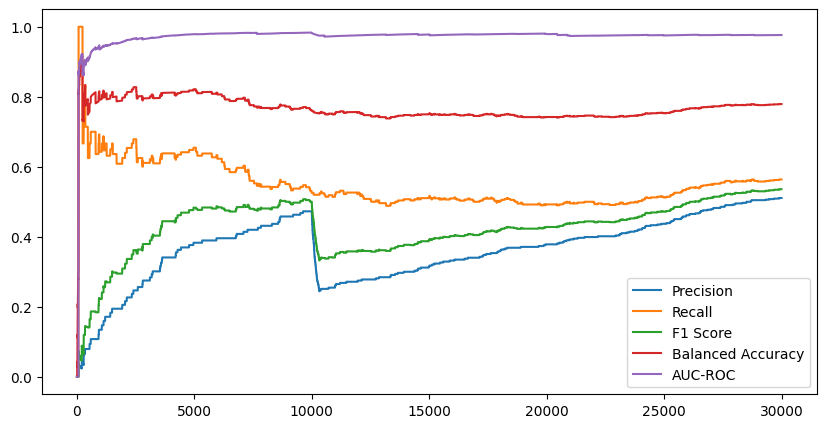

In [15]:
plt.figure(figsize=(10, 5))
plt.plot(metrics_results['precision'], label='Precision')
plt.plot(metrics_results['recall'], label='Recall')
plt.plot(metrics_results['f1'], label='F1 Score')
plt.plot(metrics_results['balanced_accuracy'], label='Balanced Accuracy')
plt.plot(metrics_results['rocauc'], label='AUC-ROC')
plt.xticks(range(0, N_SAMPLES*3+1, 5000))
plt.legend()
plt.show()

#### One-Class SVM

In [16]:
scaler = preprocessing.MinMaxScaler()

model = anomaly.QuantileFilter(
    anomaly_detector=anomaly.OneClassSVM(),
    q=0.95
)

X = df[['values']]
y = df['anomaly']

grid = {
    'anomaly_detector': [
        (anomaly.OneClassSVM, {
            'nu': [0.01, 0.05, 0.1, 0.2, 0.3]
        })
    ],
    'q': [0.9, 0.95, 0.99]
}

models = utils.expand_param_grid(model, grid)
print("Number of models to test: ", len(models))

best_metric = -1
best_model = None
for model in models:
    metrics_results = run_and_evaluate_model(scaler, model, X, y, progress_bar=False)

    final_precision = metrics_results['precision'][-1]
    final_recall = metrics_results['recall'][-1]
    final_f1 = metrics_results['f1'][-1]
    final_balanced_accuracy = metrics_results['balanced_accuracy'][-1]
    final_rocauc = metrics_results['rocauc'][-1]

    composite_score = 0.1*final_precision + 0.1*final_recall + 0.1*final_f1 + 0.35*final_balanced_accuracy + 0.35*final_rocauc

    if composite_score > best_metric:
        best_metric = composite_score
        best_model = model

Number of models to test:  15


In [17]:
best_model

QuantileFilter (
  anomaly_detector=OneClassSVM (
    nu=0.01
    optimizer=SGD (
      lr=Constant (
        learning_rate=0.01
      )
    )
    intercept_lr=Constant (
      learning_rate=0.01
    )
    clip_gradient=1e+12
    initializer=Zeros ()
  )
  q=0.95
  protect_anomaly_detector=True
)

In [18]:
scaler = preprocessing.MinMaxScaler()

X = df[['values']]
y = df['anomaly']

metrics_results = run_and_evaluate_model(scaler, best_model, X, y)

print(f"Precision: {metrics_results['precision'][-1]*100:.2f}")
print(f"Recall: {metrics_results['recall'][-1]*100:.2f}")
print(f"F1 Score: {metrics_results['f1'][-1]*100:.2f}")
print(f"Balanced accuracy: {metrics_results['balanced_accuracy'][-1]*100:.2f}")
print(f"ROCAUC: {metrics_results['rocauc'][-1]*100:.2f}")

100%|██████████| 30000/30000 [00:04<00:00, 6506.52it/s]

Precision: 2.30
Recall: 45.30
F1 Score: 4.38
Balanced accuracy: 62.99
ROCAUC: 52.94


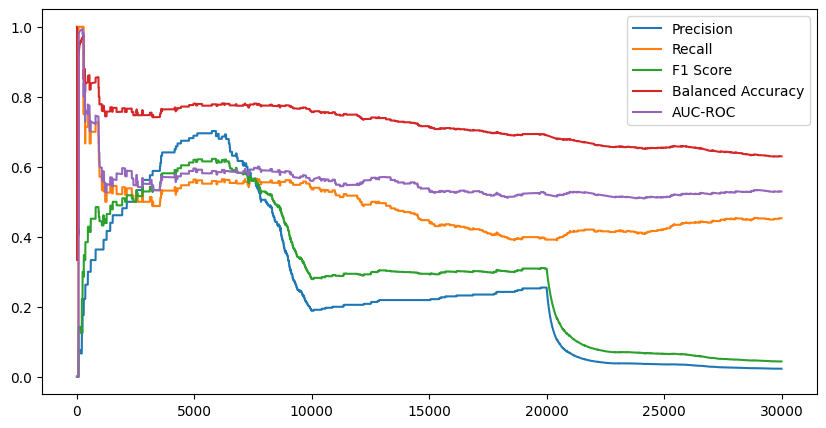

In [19]:
plt.figure(figsize=(10, 5))
plt.plot(metrics_results['precision'], label='Precision')
plt.plot(metrics_results['recall'], label='Recall')
plt.plot(metrics_results['f1'], label='F1 Score')
plt.plot(metrics_results['balanced_accuracy'], label='Balanced Accuracy')
plt.plot(metrics_results['rocauc'], label='AUC-ROC')
plt.xticks(range(0, N_SAMPLES*3+1, 5000))
plt.legend()
plt.show()

#### Gaussian Scorer

In [20]:
scaler = preprocessing.MinMaxScaler()

model = anomaly.QuantileFilter(
    anomaly_detector=anomaly.GaussianScorer(),
    q=0.95
)

X = df[['values']]
y = df['anomaly']

grid = {
    'anomaly_detector': [
        (anomaly.GaussianScorer, {
            'window_size': [None, 1, 25, 50, 100, 250, 500, 1000]
        })
    ],
    'q': [0.9, 0.95, 0.99]
}

models = utils.expand_param_grid(model, grid)
print("Number of models to test: ", len(models))

best_metric = -1
best_model = None
for model in models:
    metrics_results = run_and_evaluate_model(scaler, model, X, y, progress_bar=False)

    final_precision = metrics_results['precision'][-1]
    final_recall = metrics_results['recall'][-1]
    final_f1 = metrics_results['f1'][-1]
    final_balanced_accuracy = metrics_results['balanced_accuracy'][-1]
    final_rocauc = metrics_results['rocauc'][-1]

    composite_score = 0.1*final_precision + 0.1*final_recall + 0.1*final_f1 + 0.35*final_balanced_accuracy + 0.35*final_rocauc

    if composite_score > best_metric:
        best_metric = composite_score
        best_model = model

Number of models to test:  24


c:\Users\34697\AppData\Local\Programs\Python\Python312\Lib\site-packages\river\proba\gaussian.py:64: RuntimeWarning: invalid value encountered in scalar power
  return self._var.get() ** 0.5


In [21]:
best_model

QuantileFilter (
  anomaly_detector=GaussianScorer (
    window_size=None
    grace_period=100
  )
  q=0.99
  protect_anomaly_detector=True
)

In [22]:
scaler = preprocessing.MinMaxScaler()

X = df[['values']]
y = df['anomaly']

metrics_results = run_and_evaluate_model(scaler, best_model, X, y)

print(f"Precision: {metrics_results['precision'][-1]*100:.2f}")
print(f"Recall: {metrics_results['recall'][-1]*100:.2f}")
print(f"F1 Score: {metrics_results['f1'][-1]*100:.2f}")
print(f"Balanced accuracy: {metrics_results['balanced_accuracy'][-1]*100:.2f}")
print(f"ROCAUC: {metrics_results['rocauc'][-1]*100:.2f}")

100%|██████████| 30000/30000 [00:04<00:00, 6033.99it/s]

Precision: 100.00
Recall: 100.00
F1 Score: 100.00
Balanced accuracy: 100.00
ROCAUC: 100.00


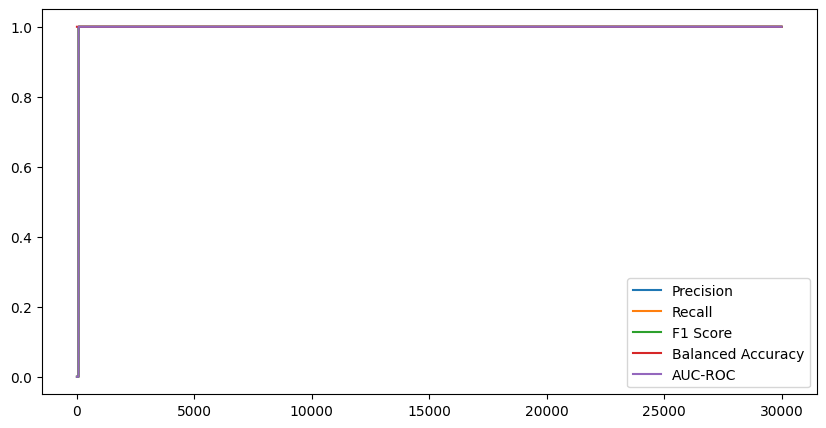

In [23]:
plt.figure(figsize=(10, 5))
plt.plot(metrics_results['precision'], label='Precision')
plt.plot(metrics_results['recall'], label='Recall')
plt.plot(metrics_results['f1'], label='F1 Score')
plt.plot(metrics_results['balanced_accuracy'], label='Balanced Accuracy')
plt.plot(metrics_results['rocauc'], label='AUC-ROC')
plt.xticks(range(0, N_SAMPLES*3+1, 5000))
plt.legend()
plt.show()

## <a id='toc3'></a>3. Concept drift detection algorithms

#### ADWIN

Number of drifts detected: 2
Change detected at indices: [10079, 20063]


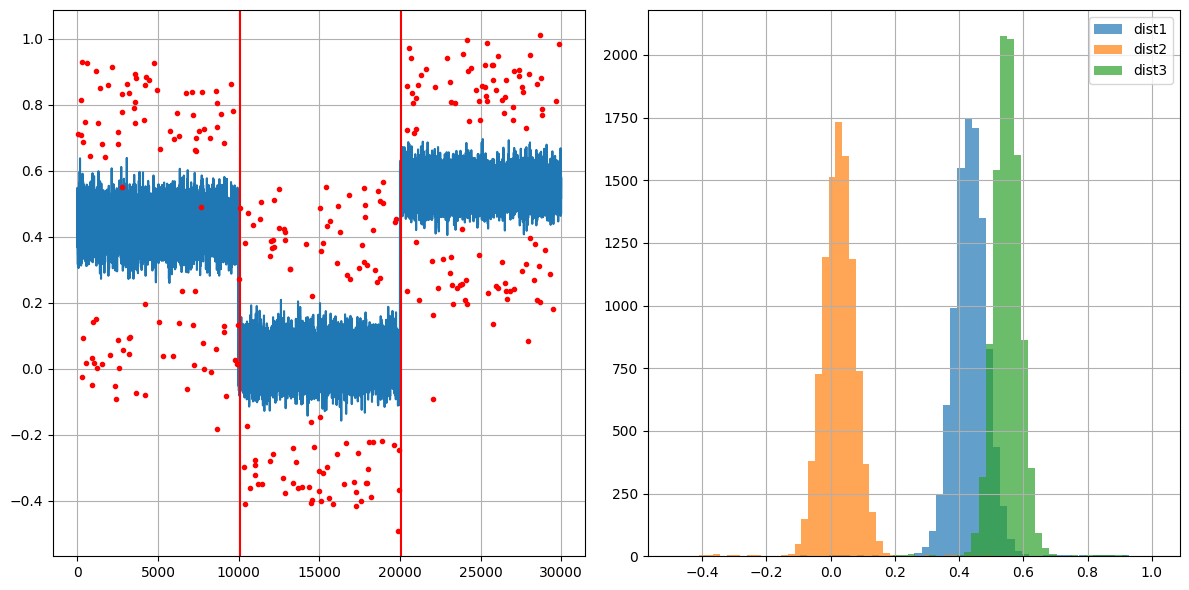

In [24]:
# Without preprocessing, the model is able to detect the drifts

drift_detector = drift.ADWIN()
drifts = []

X = df[['values']]
y = df['anomaly']

for i, x in enumerate(X.values):
    drift_detector.update(x)
    if drift_detector.drift_detected:
        drifts.append(i)

print("Number of drifts detected:", len(drifts))
print("Change detected at indices:", drifts)
plot_stream(df, drifts)

Number of drifts detected: 8
Change detected at indices: [479, 3551, 9311, 10079, 10527, 20063, 22431, 27359]


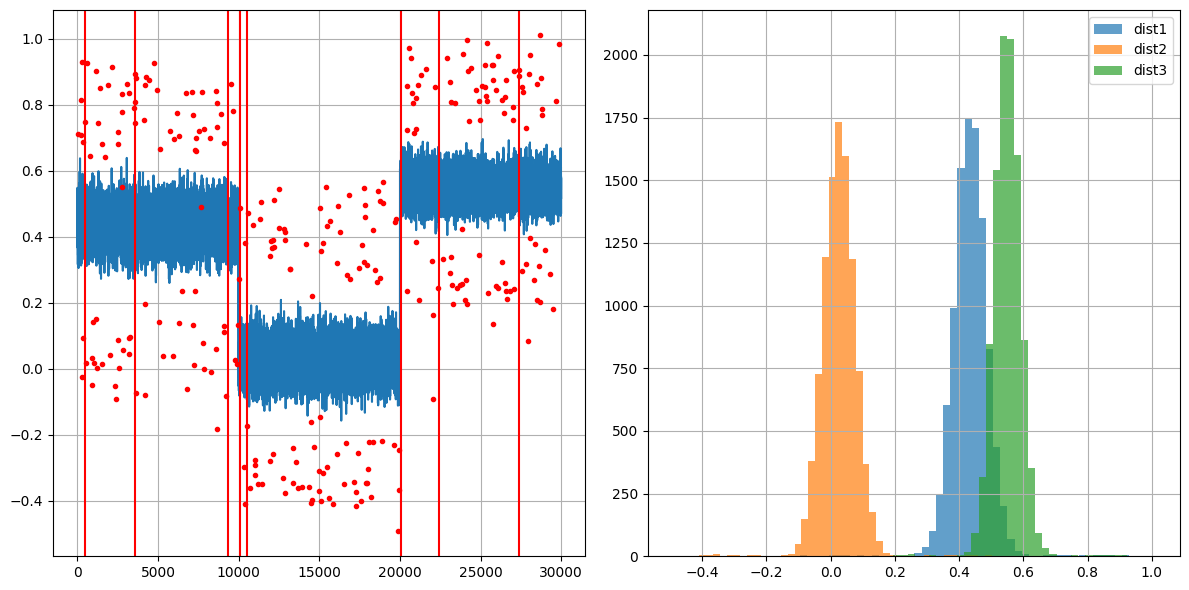

In [25]:
# With preprocessing (scaling to [0, 1]), the model detects drifts at wrong indices, 
# in addition to the correct ones

scaler = preprocessing.MinMaxScaler()
drift_detector = drift.ADWIN()
drifts = []

X = df[['values']]
y = df['anomaly']

for i, x in enumerate(X.values):
    x = {'values': x}
    scaler.learn_one(x)
    x = scaler.transform_one(x)
    
    drift_detector.update(x['values'])
    if drift_detector.drift_detected:
        drifts.append(i)

print("Number of drifts detected:", len(drifts))
print("Change detected at indices:", drifts)
plot_stream(df, drifts)

#### KSWIN

Number of drifts detected: 49
Change detected at indices: [359, 1697, 1828, 2001, 4291, 5275, 5462, 6285, 6731, 7383, 7727, 7850, 8264, 8637, 8993, 9565, 10012, 11570, 15809, 15974, 16623, 17915, 18068, 18231, 18419, 18849, 18975, 19096, 19278, 19577, 20008, 21232, 21786, 23375, 24061, 24716, 25610, 25715, 26112, 26390, 26697, 27001, 27257, 27366, 27740, 27932, 29459, 29570, 29973]


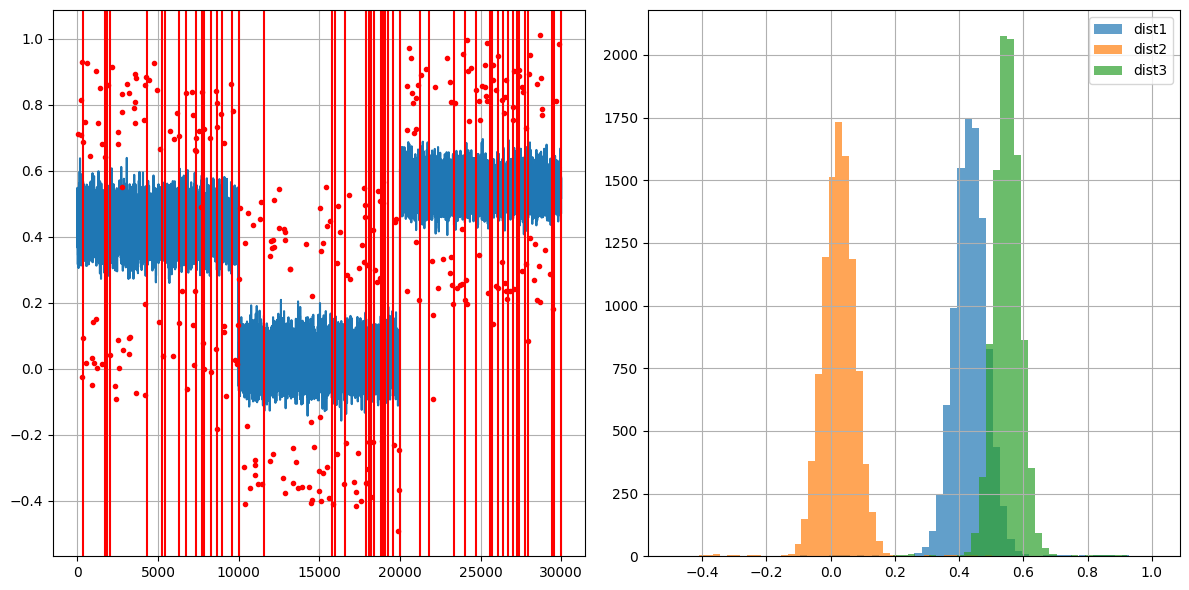

In [26]:
drift_detector = drift.KSWIN(seed=42)
drifts = []

X = df[['values']]
y = df['anomaly']

for i, x in enumerate(X.values):
    drift_detector.update(x)
    if drift_detector.drift_detected:
        drifts.append(i)

print("Number of drifts detected:", len(drifts))
print("Change detected at indices:", drifts)
plot_stream(df, drifts)

Number of drifts detected: 2
Change detected at indices: [10016, 20017]


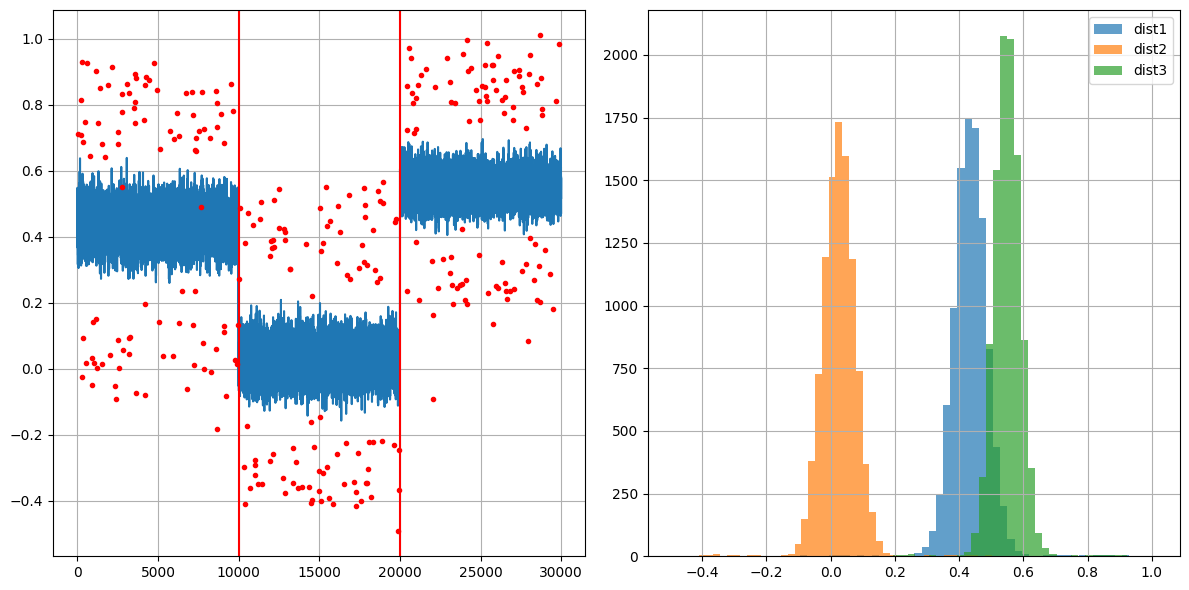

In [27]:
drift_detector = drift.KSWIN(seed=42, alpha=0.00001)
drifts = []

X = df[['values']]
y = df['anomaly']

for i, x in enumerate(X.values):
    drift_detector.update(x)
    if drift_detector.drift_detected:
        drifts.append(i)

print("Number of drifts detected:", len(drifts))
print("Change detected at indices:", drifts)
plot_stream(df, drifts)

Number of drifts detected: 4
Change detected at indices: [302, 10016, 10357, 20017]


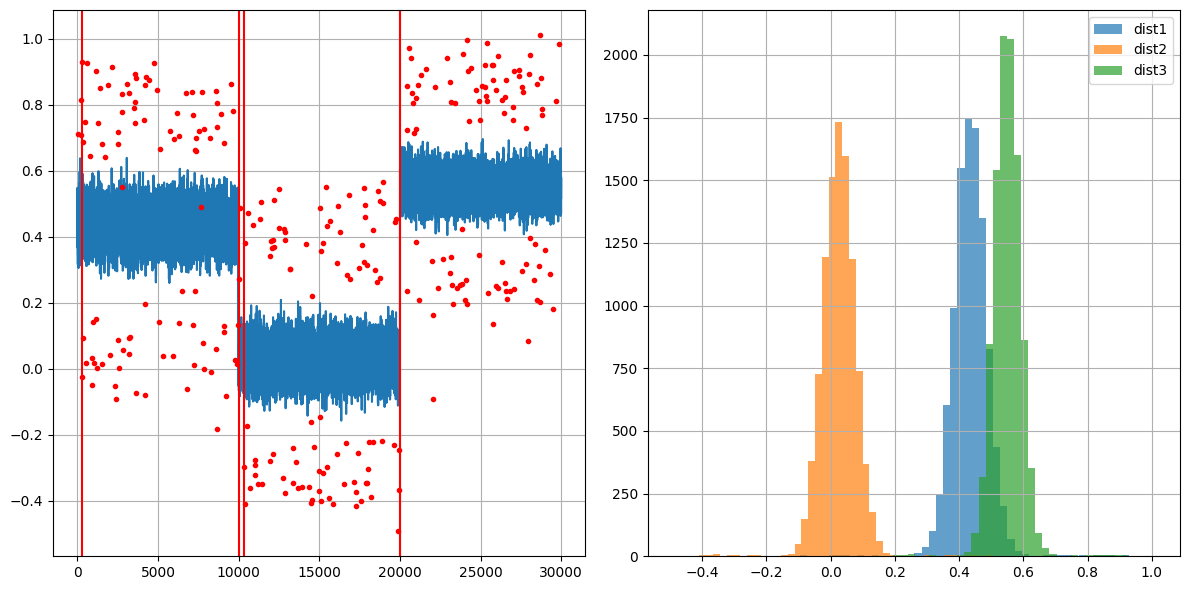

In [39]:
# With preprocessing (scaling to [0, 1]), the model detects many more drifts than without preprocessing

scaler = preprocessing.MinMaxScaler()
drift_detector = drift.KSWIN(seed=42, alpha=0.00001)
drifts = []

X = df[['values']]
y = df['anomaly']

for i, x in enumerate(X.values):
    x = {'values': x}
    scaler.learn_one(x)
    x = scaler.transform_one(x)
    
    drift_detector.update(x['values'])
    if drift_detector.drift_detected:
        drifts.append(i)

print("Number of drifts detected:", len(drifts))
print("Change detected at indices:", drifts)
plot_stream(df, drifts)

#### Page-Hinkley

Number of drifts detected: 2
Change detected at indices: [10120, 20095]


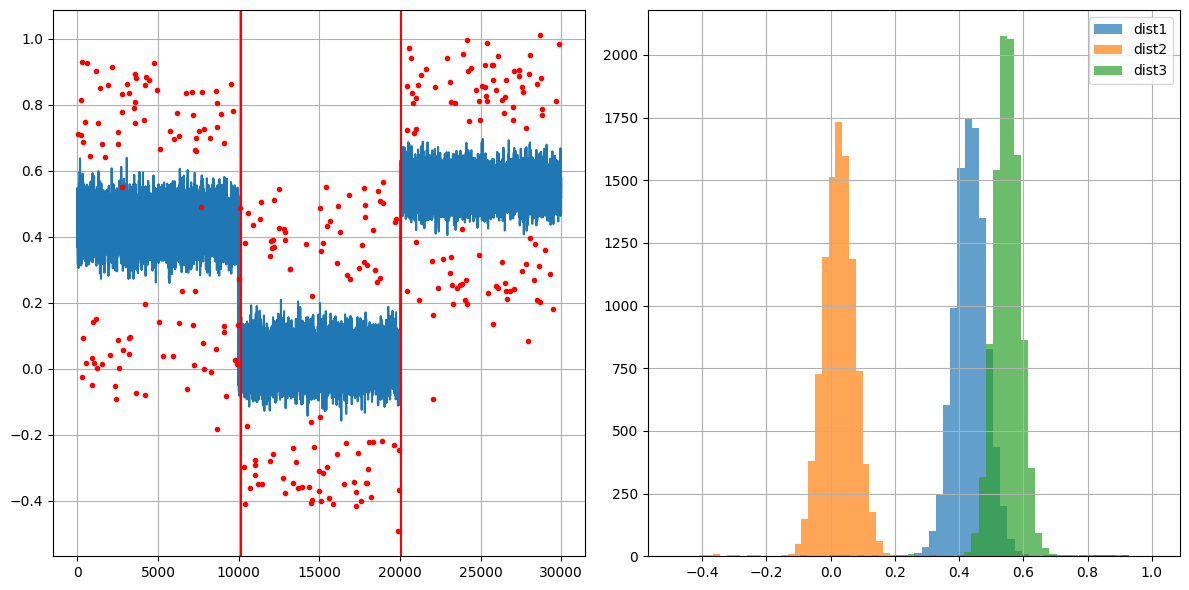

In [29]:
drift_detector = drift.PageHinkley()
drifts = []

X = df[['values']]
y = df['anomaly']

for i, x in enumerate(X.values):
    drift_detector.update(x)
    if drift_detector.drift_detected:
        drifts.append(i)

print("Number of drifts detected:", len(drifts))
print("Change detected at indices:", drifts)
plot_stream(df, drifts)

Number of drifts detected: 4
Change detected at indices: [1071, 9722, 10187, 20067]


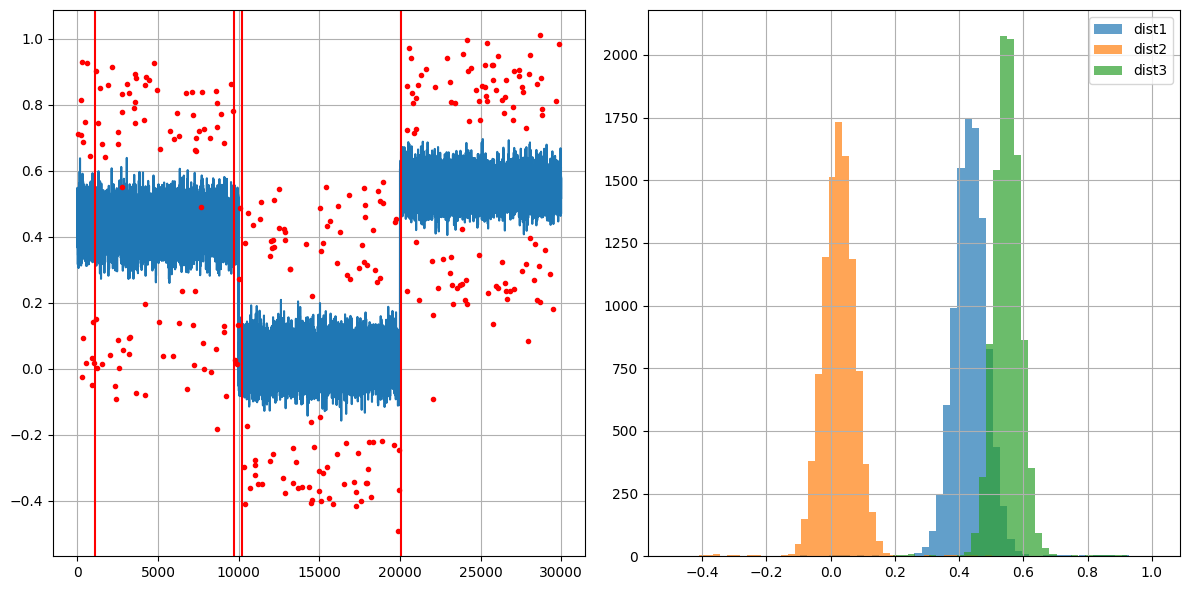

In [30]:
# With preprocessing (scaling to [0, 1]), the model detects more drifts than without preprocessing

scaler = preprocessing.MinMaxScaler()
drift_detector = drift.PageHinkley()
drifts = []

X = df[['values']]
y = df['anomaly']

for i, x in enumerate(X.values):
    x = {'values': x}
    scaler.learn_one(x)
    x = scaler.transform_one(x)
    
    drift_detector.update(x['values'])
    if drift_detector.drift_detected:
        drifts.append(i)

print("Number of drifts detected:", len(drifts))
print("Change detected at indices:", drifts)
plot_stream(df, drifts)

## <a id='toc4'></a>4. Anomaly detection algorithms with concept drift adaptation

In [31]:
def run_and_evaluate_model_with_drift_detector(scaler, base_model, drift_detector, X, y, progress_bar=True):
    """
    Run the drift detector, scaler and model on the data and evaluate its performance.

    INPUTS:
    - scaler: the scaler to normalize the data
    - model: river.anomaly.base.AnomalyDetector, the anomaly detection model
    - X: pd.DataFrame containing the features
    - y: pd.Series containing the labels
    - progress_bar: bool, whether to show a progress bar or not

    OUTPUTS:
    - metrics_results: dict, the results of the evaluated metrics
    - drifts_detected: list of ints, the indices where drifts were detected
    """
    model = base_model.clone()

    precision = metrics.Precision()
    recall = metrics.Recall()
    f1 = metrics.F1()
    balanced_accuracy = metrics.BalancedAccuracy()
    rocauc = metrics.ROCAUC()

    metrics_results = {
        'precision': [],
        'recall': [],
        'f1': [],
        'balanced_accuracy': [],
        'rocauc': []
    }

    drifts_detected = []

    if progress_bar:
        data_stream = tqdm(stream.iter_pandas(X, y), total=N_SAMPLES*3)
    else:
        data_stream = stream.iter_pandas(X, y)

    for i, (x, y) in enumerate(data_stream):

        drift_detector.update(x['values'])
        if drift_detector.drift_detected:
            drifts_detected.append(i)
            model = base_model.clone()    # Retrain the model
        
        scaler.learn_one(x)
        x = scaler.transform_one(x)
            
        try:
            score = model.score_one(x)
        except:
            score = model.score_one(x, y)

        is_anomaly = model.classify(score)

        try:
            model.learn_one(x)
        except:
            model.learn_one(x, y)

        rocauc.update(y, score)
        precision.update(y, is_anomaly)
        recall.update(y, is_anomaly)
        f1.update(y, is_anomaly)
        balanced_accuracy.update(y, is_anomaly)

        metrics_results['precision'].append(precision.get())
        metrics_results['recall'].append(recall.get())
        metrics_results['f1'].append(f1.get())
        metrics_results['balanced_accuracy'].append(balanced_accuracy.get())
        metrics_results['rocauc'].append(rocauc.get())

    return metrics_results, drifts_detected

#### KSWIN + Half-Space Trees

In [32]:
scaler = preprocessing.MinMaxScaler()
model = anomaly.QuantileFilter(
    anomaly.HalfSpaceTrees(n_trees=1, height=5, window_size=50, seed=42),
    q=0.99
)
drift_detector = drift.KSWIN(seed=42, alpha=0.00001)

X = df[['values']]
y = df['anomaly']

metrics_results, drifts_detected = run_and_evaluate_model_with_drift_detector(scaler, model, drift_detector, X, y)

print(f"Precision: {metrics_results['precision'][-1]*100:.2f}")
print(f"Recall: {metrics_results['recall'][-1]*100:.2f}")
print(f"F1 Score: {metrics_results['f1'][-1]*100:.2f}")
print(f"Balanced accuracy: {metrics_results['balanced_accuracy'][-1]*100:.2f}")
print(f"ROCAUC: {metrics_results['rocauc'][-1]*100:.2f}")

100%|██████████| 30000/30000 [00:20<00:00, 1438.56it/s]

Precision: 46.15
Recall: 64.43
F1 Score: 53.78
Balanced accuracy: 81.84
ROCAUC: 97.92


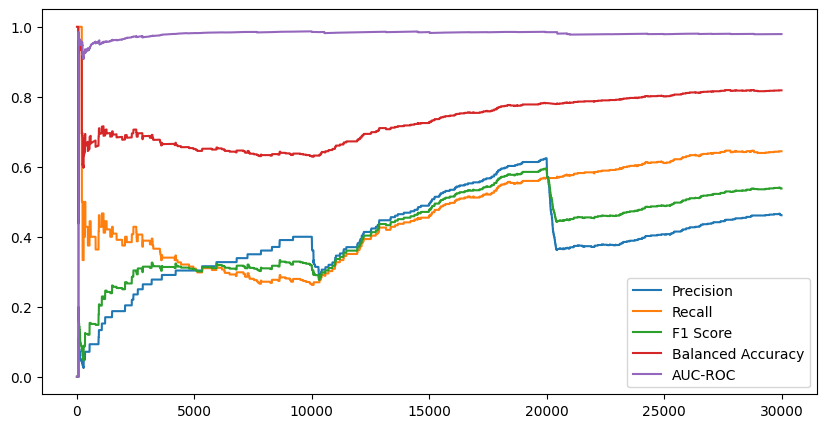

In [33]:
plt.figure(figsize=(10, 5))
plt.plot(metrics_results['precision'], label='Precision')
plt.plot(metrics_results['recall'], label='Recall')
plt.plot(metrics_results['f1'], label='F1 Score')
plt.plot(metrics_results['balanced_accuracy'], label='Balanced Accuracy')
plt.plot(metrics_results['rocauc'], label='AUC-ROC')
plt.xticks(range(0, N_SAMPLES*3+1, 5000))
plt.legend()
plt.show()

#### KSWIN + One-Class SVM

In [34]:
scaler = preprocessing.MinMaxScaler()
model = anomaly.QuantileFilter(
    anomaly.OneClassSVM(nu=0.01),
    q=0.95
)
drift_detector = drift.KSWIN(seed=42, alpha=0.00001)

X = df[['values']]
y = df['anomaly']

metrics_results, drifts_detected = run_and_evaluate_model_with_drift_detector(scaler, model, drift_detector, X, y)

print(f"Precision: {metrics_results['precision'][-1]*100:.2f}")
print(f"Recall: {metrics_results['recall'][-1]*100:.2f}")
print(f"F1 Score: {metrics_results['f1'][-1]*100:.2f}")
print(f"Balanced accuracy: {metrics_results['balanced_accuracy'][-1]*100:.2f}")
print(f"ROCAUC: {metrics_results['rocauc'][-1]*100:.2f}")

  0%|          | 0/30000 [00:00<?, ?it/s]

100%|██████████| 30000/30000 [00:24<00:00, 1227.56it/s]

Precision: 1.48
Recall: 54.36
F1 Score: 2.87
Balanced accuracy: 58.98
ROCAUC: 50.69


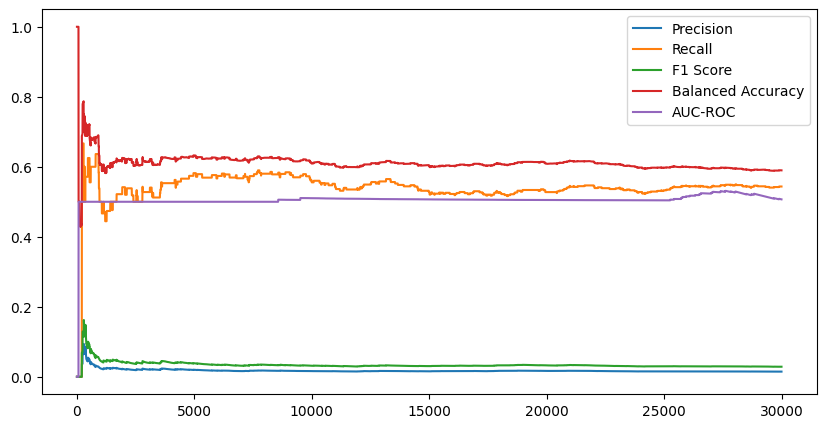

In [35]:
plt.figure(figsize=(10, 5))
plt.plot(metrics_results['precision'], label='Precision')
plt.plot(metrics_results['recall'], label='Recall')
plt.plot(metrics_results['f1'], label='F1 Score')
plt.plot(metrics_results['balanced_accuracy'], label='Balanced Accuracy')
plt.plot(metrics_results['rocauc'], label='AUC-ROC')
plt.xticks(range(0, N_SAMPLES*3+1, 5000))
plt.legend()
plt.show()

#### KSWIN + Gaussian Scorer

In [36]:
scaler = preprocessing.MinMaxScaler()
model = anomaly.QuantileFilter(
    anomaly.GaussianScorer(window_size=None),
    q=0.99
)
drift_detector = drift.KSWIN(seed=42, alpha=0.00001)

X = df[['values']]
y = df['anomaly']

metrics_results, drifts_detected = run_and_evaluate_model_with_drift_detector(scaler, model, drift_detector, X, y)

print(f"Precision: {metrics_results['precision'][-1]*100:.2f}")
print(f"Recall: {metrics_results['recall'][-1]*100:.2f}")
print(f"F1 Score: {metrics_results['f1'][-1]*100:.2f}")
print(f"Balanced accuracy: {metrics_results['balanced_accuracy'][-1]*100:.2f}")
print(f"ROCAUC: {metrics_results['rocauc'][-1]*100:.2f}")

  0%|          | 0/30000 [00:00<?, ?it/s]

 67%|██████▋   | 19978/30000 [00:14<00:06, 1498.25it/s]c:\Users\34697\AppData\Local\Programs\Python\Python312\Lib\site-packages\river\proba\gaussian.py:90: RuntimeWarning: invalid value encountered in scalar divide
  return 0.5 * (1.0 + math.erf((x - self.mu) / (self.sigma * math.sqrt(2.0))))
c:\Users\34697\AppData\Local\Programs\Python\Python312\Lib\site-packages\river\proba\gaussian.py:90: RuntimeWarning: invalid value encountered in scalar divide
  return 0.5 * (1.0 + math.erf((x - self.mu) / (self.sigma * math.sqrt(2.0))))
c:\Users\34697\AppData\Local\Programs\Python\Python312\Lib\site-packages\river\proba\gaussian.py:90: RuntimeWarning: invalid value encountered in scalar divide
  return 0.5 * (1.0 + math.erf((x - self.mu) / (self.sigma * math.sqrt(2.0))))
c:\Users\34697\AppData\Local\Programs\Python\Python312\Lib\site-packages\river\proba\gaussian.py:90: RuntimeWarning: invalid value encountered in scalar divide
  return 0.5 * (1.0 + math.erf((x - self.mu) / (self.sigma * math.sq

Precision: 92.19
Recall: 98.99
F1 Score: 95.47
Balanced accuracy: 99.45
ROCAUC: 98.63


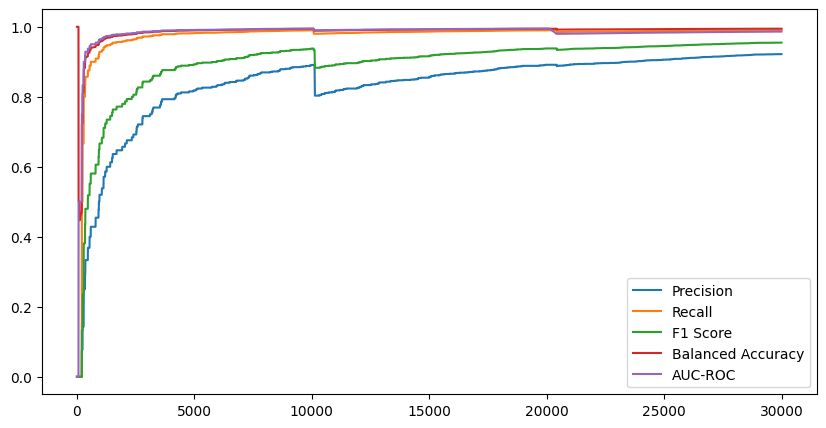

In [37]:
plt.figure(figsize=(10, 5))
plt.plot(metrics_results['precision'], label='Precision')
plt.plot(metrics_results['recall'], label='Recall')
plt.plot(metrics_results['f1'], label='F1 Score')
plt.plot(metrics_results['balanced_accuracy'], label='Balanced Accuracy')
plt.plot(metrics_results['rocauc'], label='AUC-ROC')
plt.xticks(range(0, N_SAMPLES*3+1, 5000))
plt.legend()
plt.show()